# TelecomX – Parte 2: Modelagem Preditiva de Churn

Este notebook dá continuidade ao desafio da Telecom X, que tem por objetivo
prever quais clientes têm maior probabilidade de cancelar os serviços (churn).
A partir do conjunto de dados tratado na parte 1, iremos preparar os dados,
explorar a relação entre variáveis e a evasão, construir e comparar modelos
classificadores e interpretar os fatores mais importantes para a previsão.

**Etapas principais:**

1. **Carga e limpeza** do dataset preparado na parte 1.
2. **Pré‑processamento:** remoção de colunas irrelevantes, codificação
   (one‑hot) das variáveis categóricas e, quando necessário, normalização/padronização.
3. **Análise da proporção de churn** e verificação de desequilíbrio das classes.
4. **Análises exploratórias direcionadas** e **matriz de correlação** para
   selecionar variáveis candidatas.
5. **Divisão** do conjunto de dados em treino e teste.
6. **Construção e avaliação** de ao menos dois modelos: um modelo que
   requer normalização (Regressão Logística e KNN) e um modelo baseado em
   árvore (Random Forest). Também exploramos versões com balanço de classes
   via SMOTE e tuning de hiperparâmetros.
7. **Análise da importância das variáveis** e dos coeficientes dos modelos.
8. **Conclusão** com discussão de desempenho e fatores mais relevantes.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
    classification_report
)

# Tentativa de importar SMOTE. Se indisponível, o bloco correspondente será ignorado.
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_SMOTE = True
except Exception:
    HAS_SMOTE = False

import warnings
warnings.filterwarnings('ignore')



In [2]:

# Caminho do dataset limpo gerado na parte 1
DATA_PATH = '/home/oai/share/telecomx_clean.csv'
df = pd.read_csv(DATA_PATH)

print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")
df.head()


Dataset carregado com 7267 linhas e 22 colunas.


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,daily_charge
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


In [3]:

# Remover colunas que não contribuem para a modelagem, como identificadores
cols_to_drop = [col for col in df.columns if col.lower().startswith('customer') and col.lower().endswith('id')]
if 'customerID' in df.columns:
    cols_to_drop.append('customerID')

df = df.drop(columns=cols_to_drop, errors='ignore')

# Converter a variável alvo para binário: Yes -> 1, No -> 0
df['Churn'] = df['Churn'].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})

# Exibir as colunas restantes e tipos
df.dtypes


Churn                          int64
customer_gender               object
customer_SeniorCitizen         int64
customer_Partner              object
customer_Dependents           object
customer_tenure                int64
phone_PhoneService            object
phone_MultipleLines           object
internet_InternetService      object
internet_OnlineSecurity       object
internet_OnlineBackup         object
internet_DeviceProtection     object
internet_TechSupport          object
internet_StreamingTV          object
internet_StreamingMovies      object
account_Contract              object
account_PaperlessBilling      object
account_PaymentMethod         object
account_Charges_Monthly      float64
account_Charges_Total        float64
daily_charge                 float64
dtype: object

In [4]:

# Separar variáveis numéricas e categóricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir a coluna alvo da lista de numéricas
numeric_cols = [c for c in numeric_cols if c != 'Churn']
categorical_cols = [c for c in df.columns if c not in numeric_cols + ['Churn']]

print('Variáveis numéricas:', numeric_cols)
print('Variáveis categóricas:', categorical_cols)


Variáveis numéricas: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total', 'daily_charge']
Variáveis categóricas: ['customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod']


Proporção de churn (0 = não, 1 = sim):
0    0.74281
1    0.25719
Name: proporção, dtype: float64


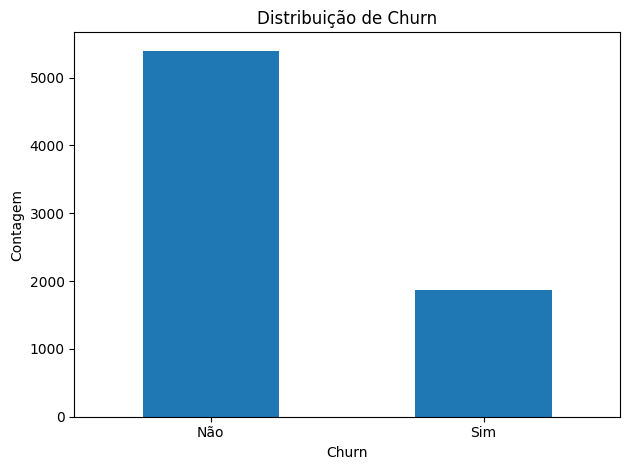

In [5]:

import matplotlib.pyplot as plt

churn_counts = df['Churn'].value_counts().sort_index()
print('Proporção de churn (0 = não, 1 = sim):')
print((churn_counts / len(df)).rename('proporção'))

# Gráfico da distribuição de churn
plt.figure()
churn_counts.plot(kind='bar')
plt.title('Distribuição de Churn')
plt.xlabel('Churn')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['Não', 'Sim'], rotation=0)
plt.tight_layout()
plt.savefig('/home/oai/share/churn_distribution_complete.png')
plt.show()


Matriz de correlação (primeiras linhas):
                         customer_SeniorCitizen  customer_tenure  \
customer_SeniorCitizen                 1.000000         0.018187   
customer_tenure                        0.018187         1.000000   
account_Charges_Monthly                0.220388         0.247982   
account_Charges_Total                  0.104076         0.825407   
daily_charge                           0.220388         0.247982   

                         account_Charges_Monthly  account_Charges_Total  \
customer_SeniorCitizen                  0.220388               0.104076   
customer_tenure                         0.247982               0.825407   
account_Charges_Monthly                 1.000000               0.652211   
account_Charges_Total                   0.652211               1.000000   
daily_charge                            1.000000               0.652211   

                         daily_charge     Churn  
customer_SeniorCitizen       0.220388  0.146733  

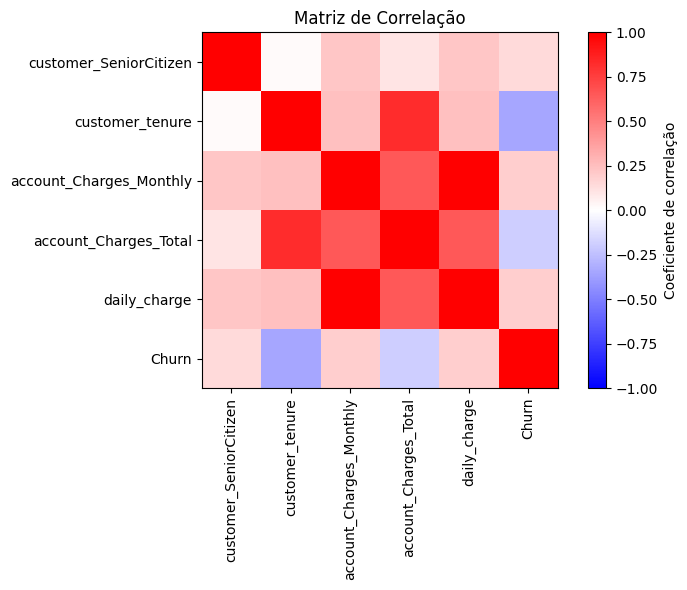

In [6]:

import matplotlib.pyplot as plt

# Calcular matriz de correlação somente para variáveis numéricas
corr_matrix = df[numeric_cols + ['Churn']].corr()
print('Matriz de correlação (primeiras linhas):')
print(corr_matrix.head())

# Heatmap simples usando matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Coeficiente de correlação')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.savefig('/home/oai/share/correlation_matrix_complete.png')
plt.show()


<Figure size 640x480 with 0 Axes>

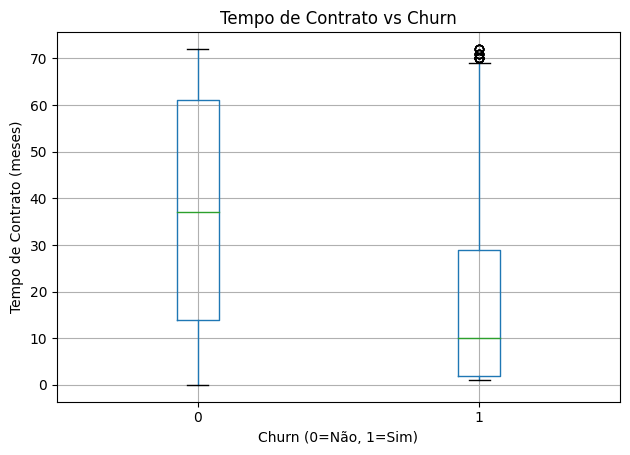

<Figure size 640x480 with 0 Axes>

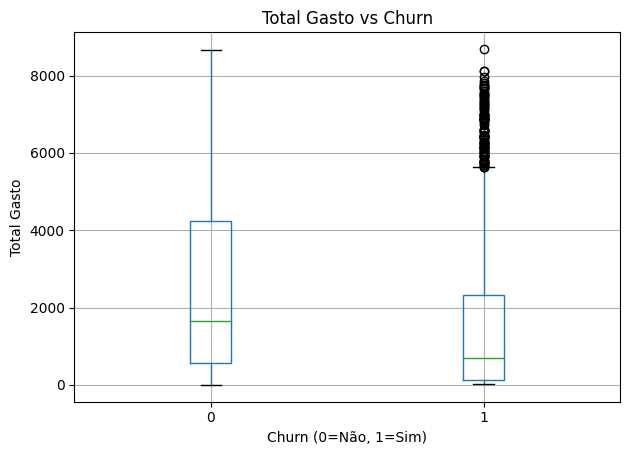

<Figure size 640x480 with 0 Axes>

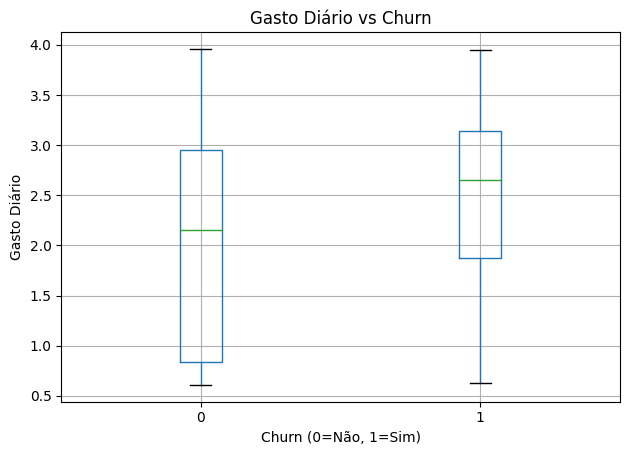

In [7]:

import matplotlib.pyplot as plt

# Boxplot: Tenure vs Churn
plt.figure()
df.boxplot(column='customer_tenure', by='Churn')
plt.title('Tempo de Contrato vs Churn')
plt.suptitle('')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Tempo de Contrato (meses)')
plt.tight_layout()
plt.savefig('/home/oai/share/tenure_vs_churn_boxplot.png')
plt.show()

# Boxplot: Total charges vs Churn
plt.figure()
df.boxplot(column='account_Charges_Total', by='Churn')
plt.title('Total Gasto vs Churn')
plt.suptitle('')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Total Gasto')
plt.tight_layout()
plt.savefig('/home/oai/share/total_charges_vs_churn_boxplot.png')
plt.show()

# Boxplot: Daily charge vs Churn
if 'daily_charge' in df.columns:
    plt.figure()
    df.boxplot(column='daily_charge', by='Churn')
    plt.title('Gasto Diário vs Churn')
    plt.suptitle('')
    plt.xlabel('Churn (0=Não, 1=Sim)')
    plt.ylabel('Gasto Diário')
    plt.tight_layout()
    plt.savefig('/home/oai/share/daily_charge_vs_churn_boxplot.png')
    plt.show()


In [8]:

from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

# Divisão estratificada preservando a proporção de churn
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Tamanho do conjunto de treino: {X_train.shape}')
print(f'Tamanho do conjunto de teste: {X_test.shape}')


Tamanho do conjunto de treino: (5813, 20)
Tamanho do conjunto de teste: (1454, 20)


In [9]:

# Pré‑processador para modelos que exigem normalização (LR, KNN)
preprocessor_norm = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Pré‑processador para modelos de árvore (sem normalização numérica)
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Definição dos modelos
lr_model = Pipeline(steps=[
    ('prep', preprocessor_norm),
    ('clf', LogisticRegression(max_iter=1000))
])

rf_model = Pipeline(steps=[
    ('prep', preprocessor_tree),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42))
])

knn_model = Pipeline(steps=[
    ('prep', preprocessor_norm),
    ('clf', KNeighborsClassifier(n_neighbors=15))
])

models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'KNN': knn_model
}



=== Logistic Regression ===
Acurácia: 0.803 | Precisão: 0.636 | Recall: 0.543 | F1: 0.586 | AUC: 0.844
Relatório de classificação:
              precision    recall  f1-score   support

           0      0.849     0.893     0.870      1080
           1      0.636     0.543     0.586       374

    accuracy                          0.803      1454
   macro avg      0.743     0.718     0.728      1454
weighted avg      0.795     0.803     0.797      1454



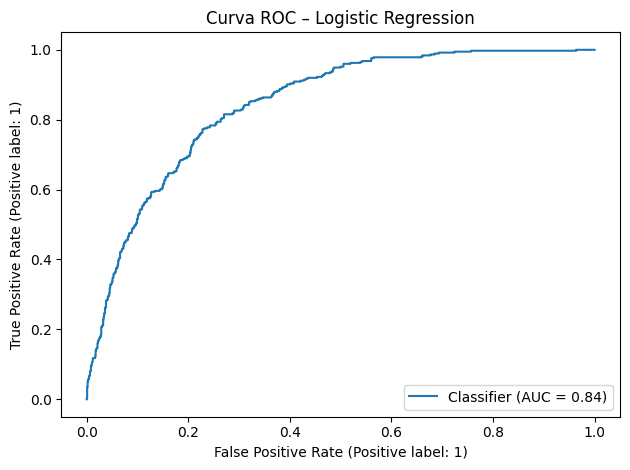

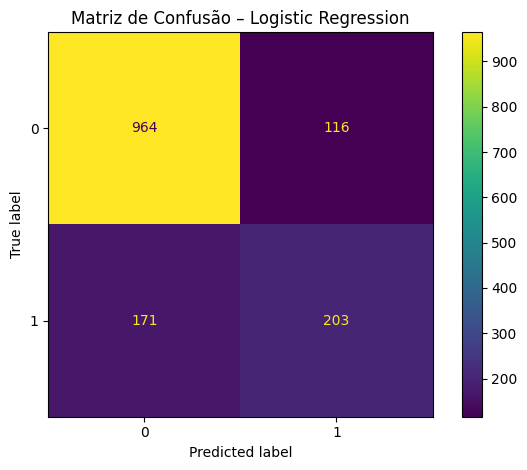


=== Random Forest ===
Acurácia: 0.779 | Precisão: 0.584 | Recall: 0.481 | F1: 0.528 | AUC: 0.819
Relatório de classificação:
              precision    recall  f1-score   support

           0      0.831     0.881     0.855      1080
           1      0.584     0.481     0.528       374

    accuracy                          0.779      1454
   macro avg      0.708     0.681     0.692      1454
weighted avg      0.767     0.779     0.771      1454



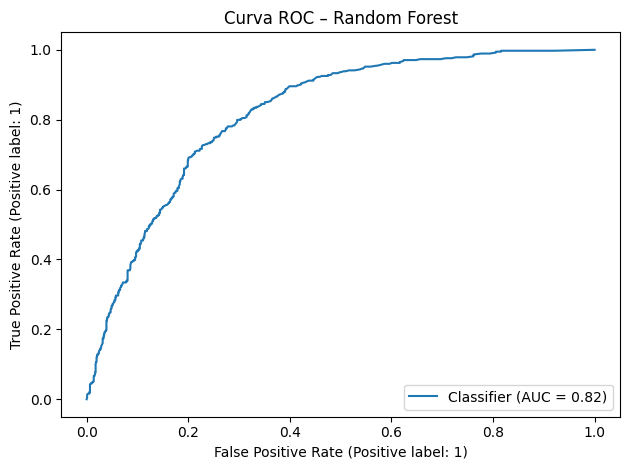

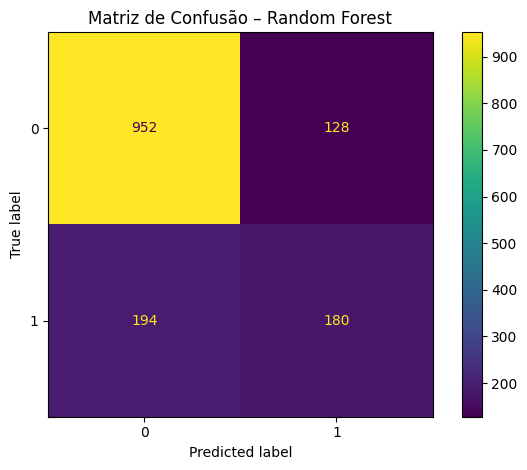


=== KNN ===
Acurácia: 0.790 | Precisão: 0.594 | Recall: 0.575 | F1: 0.584 | AUC: 0.817
Relatório de classificação:
              precision    recall  f1-score   support

           0      0.854     0.864     0.859      1080
           1      0.594     0.575     0.584       374

    accuracy                          0.790      1454
   macro avg      0.724     0.719     0.722      1454
weighted avg      0.787     0.790     0.788      1454



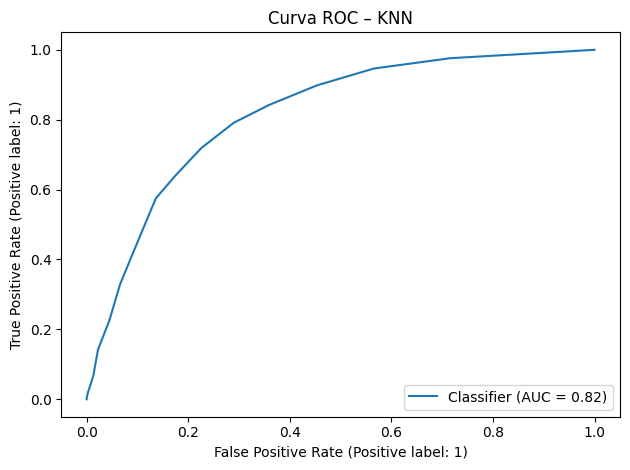

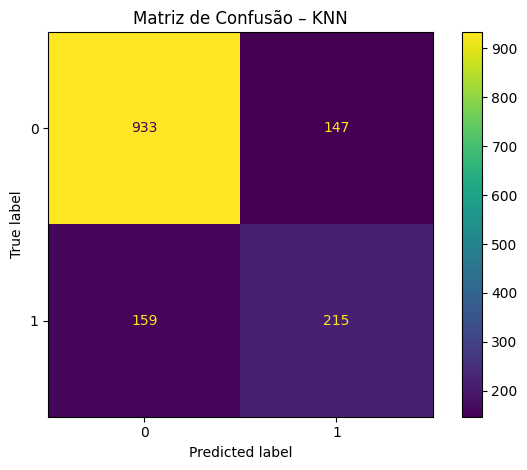

,accuracy,precision,recall,f1,auc
Logistic Regression,0.802613,0.636364,0.542781,0.585859,0.843903
Random Forest,0.778542,0.584416,0.481283,0.527859,0.818842
KNN,0.789546,0.593923,0.574866,0.584239,0.817041


In [10]:

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    # Treina o modelo, calcula métricas e plota gráficos para uma avaliação resumida.
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    # Métricas principais
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, proba) if proba is not None else np.nan
    # Impressão das métricas (linha em branco seguida pelo título)
    print()  # linha em branco para separar avaliações
    print('=== {} ==='.format(name))
    print('Acurácia: {:.3f} | Precisão: {:.3f} | Recall: {:.3f} | F1: {:.3f} | AUC: {:.3f}'.format(acc, prec, rec, f1, auc))
    # Para incluir quebra de linha no texto, usamos \n (dupla barra para escapar na string Python gerada)
    print('Relatório de classificação:\n{}'.format(classification_report(y_test, y_pred, digits=3)))
    # Curva ROC, se houver probabilidade
    if proba is not None:
        RocCurveDisplay.from_predictions(y_test, proba)
        plt.title('Curva ROC – {}'.format(name))
        plt.tight_layout()
        plt.savefig('/home/oai/share/roc_curve_{}.png'.format(name.replace(' ', '_').lower()))
        plt.show()
    # Matriz de confusão
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title('Matriz de Confusão – {}'.format(name))
    plt.tight_layout()
    plt.savefig('/home/oai/share/confusion_matrix_{}.png'.format(name.replace(' ', '_').lower()))
    plt.show()
    return {
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc
    }

results = {}
for mname, m in models.items():
    results[mname] = evaluate_model(mname, m, X_train, X_test, y_train, y_test)

import pandas as pd
results_df = pd.DataFrame({k: v for k, v in results.items()}).T.drop(columns=['model'])
results_df


In [11]:

if HAS_SMOTE:
    # Mensagem informativa (sem quebra de linha não escapada)
    print('=== Aplicando SMOTE para balancear as classes ===')
    smote = SMOTE(random_state=42)
    # Logistic Regression com SMOTE
    lr_smote = ImbPipeline(steps=[
        ('prep', preprocessor_norm),
        ('smote', smote),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    results['Logistic Regression + SMOTE'] = evaluate_model('Logistic Regression + SMOTE', lr_smote, X_train, X_test, y_train, y_test)
    # Random Forest com SMOTE
    rf_smote = ImbPipeline(steps=[
        ('prep', preprocessor_tree),
        ('smote', smote),
        ('clf', RandomForestClassifier(n_estimators=300, random_state=42))
    ])
    results['Random Forest + SMOTE'] = evaluate_model('Random Forest + SMOTE', rf_smote, X_train, X_test, y_train, y_test)
else:
    print('SMOTE não está disponível no ambiente. Pular esta etapa.')



SMOTE não está disponível no ambiente. Pular esta etapa.


=== Tuning de hiperparâmetros ===



=== Logistic Regression (GS) ===
Acurácia: 0.802 | Precisão: 0.635 | Recall: 0.540 | F1: 0.584 | AUC: 0.844
Relatório de classificação:
              precision    recall  f1-score   support

           0      0.849     0.893     0.870      1080
           1      0.635     0.540     0.584       374

    accuracy                          0.802      1454
   macro avg      0.742     0.716     0.727      1454
weighted avg      0.794     0.802     0.796      1454



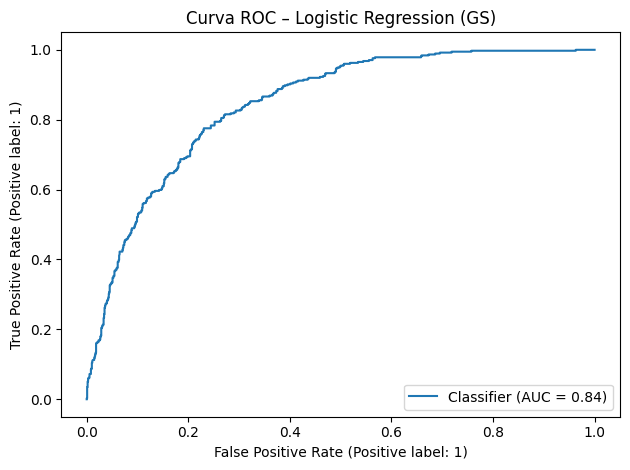

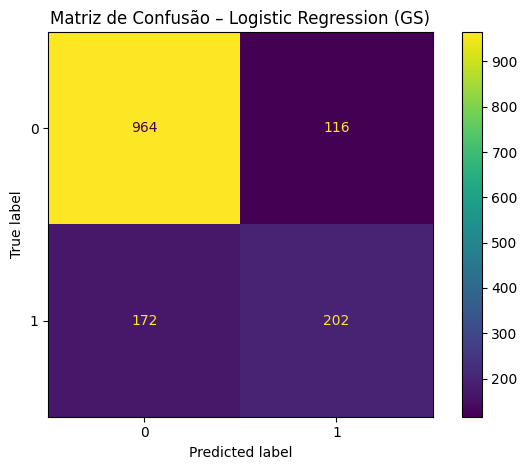


=== Random Forest (GS) ===
Acurácia: 0.792 | Precisão: 0.623 | Recall: 0.487 | F1: 0.547 | AUC: 0.842
Relatório de classificação:
              precision    recall  f1-score   support

           0      0.835     0.898     0.865      1080
           1      0.623     0.487     0.547       374

    accuracy                          0.792      1454
   macro avg      0.729     0.692     0.706      1454
weighted avg      0.780     0.792     0.783      1454



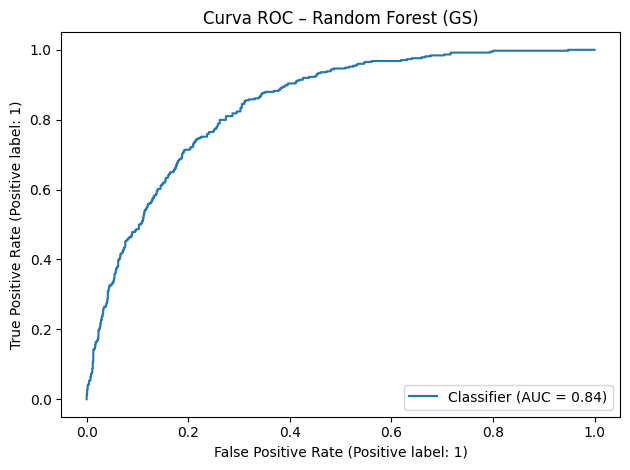

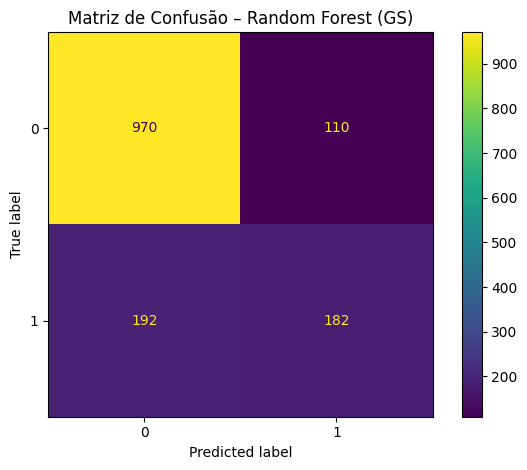

{'Logistic Regression (GS)': {'model': Pipeline(steps=[('prep',
                   ColumnTransformer(transformers=[('num', StandardScaler(),
                                                    ['customer_SeniorCitizen',
                                                     'customer_tenure',
                                                     'account_Charges_Monthly',
                                                     'account_Charges_Total',
                                                     'daily_charge']),
                                                   ('cat',
                                                    OneHotEncoder(handle_unknown='ignore'),
                                                    ['customer_gender',
                                                     'customer_Partner',
                                                     'customer_Dependents',
                                                     'phone_PhoneService',
                                

In [12]:

# Impressão do título da seção de tuning (sem quebra de linha não escapada)
print('=== Tuning de hiperparâmetros ===')
grid_results = {}

# Tuning para Logistic Regression: explorar diferentes valores de C
param_grid_lr = {'clf__C': [0.1, 1.0, 3.0]}
gs_lr = GridSearchCV(lr_model, param_grid=param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
gs_lr.fit(X_train, y_train)
grid_results['Logistic Regression (GS)'] = evaluate_model('Logistic Regression (GS)', gs_lr.best_estimator_, X_train, X_test, y_train, y_test)

# Tuning para Random Forest: explorar número de árvores e profundidade
param_grid_rf = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 10, 20]
}
gs_rf = GridSearchCV(rf_model, param_grid=param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
gs_rf.fit(X_train, y_train)
grid_results['Random Forest (GS)'] = evaluate_model('Random Forest (GS)', gs_rf.best_estimator_, X_train, X_test, y_train, y_test)

grid_results


=== Análise de Importância de Variáveis ===


Top 15 importâncias – Random Forest:
customer_tenure                           0.145164
account_Charges_Total                     0.128436
account_Contract_Month-to-month           0.097281
daily_charge                              0.095851
account_Charges_Monthly                   0.094029
internet_InternetService_Fiber optic      0.053505
account_PaymentMethod_Electronic check    0.039845
account_Contract_Two year                 0.038625
internet_InternetService_No               0.020544
account_PaperlessBilling_Yes              0.016977
internet_TechSupport_Yes                  0.015786
internet_OnlineSecurity_No                0.015724
account_Contract_One year                 0.014664
internet_InternetService_DSL              0.012863
account_PaperlessBilling_No               0.012786
dtype: float64


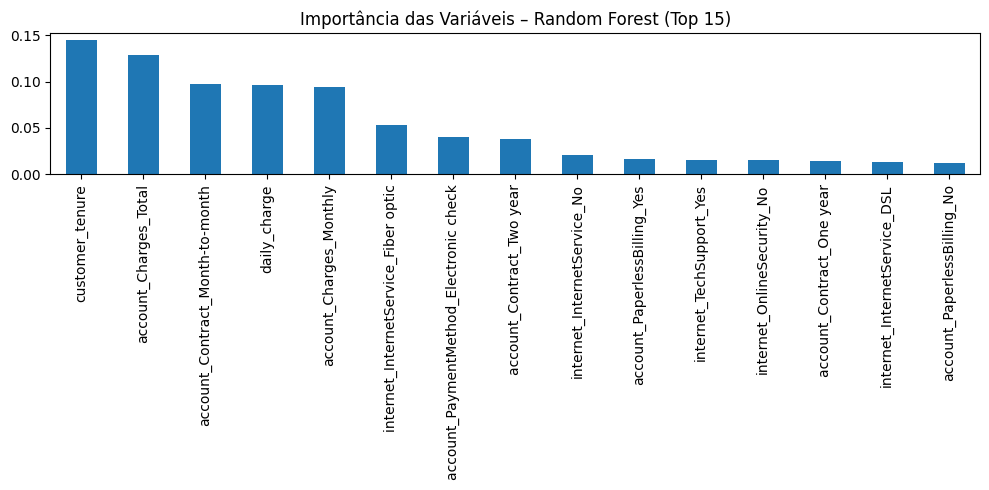

Top 15 coeficientes (por magnitude) – Logistic Regression:
customer_tenure                          -1.473172
internet_InternetService_No              -1.276974
internet_InternetService_Fiber optic      1.265785
account_Charges_Total                     0.727804
account_Contract_Two year                -0.644196
account_Contract_Month-to-month           0.632171
account_Charges_Monthly                  -0.327809
daily_charge                             -0.327809
account_PaymentMethod_Electronic check    0.278179
internet_StreamingTV_No                  -0.205071
account_PaperlessBilling_No              -0.200187
internet_StreamingTV_Yes                  0.193712
internet_StreamingMovies_No              -0.193659
account_PaperlessBilling_Yes              0.188828
internet_StreamingMovies_Yes              0.182300
dtype: float64


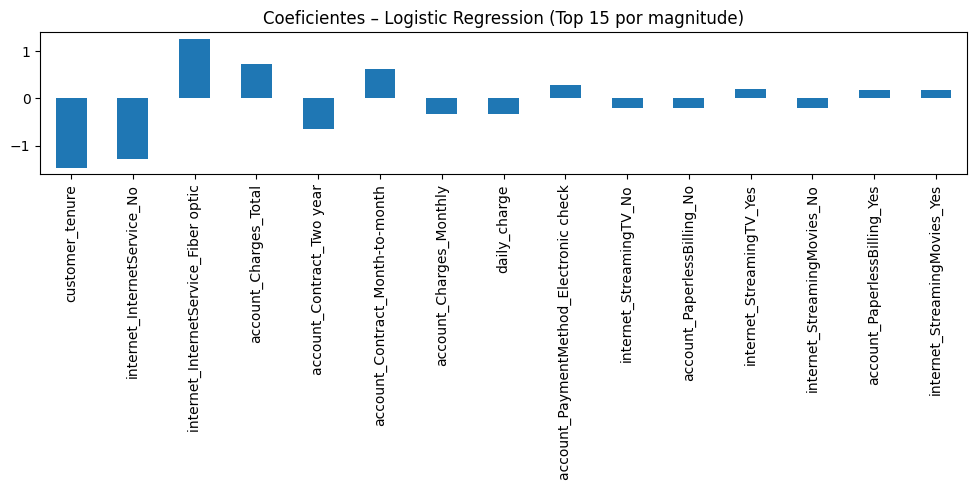

In [13]:

# Impressão do título da análise de importâncias (sem quebra de linha não escapada)
print('=== Análise de Importância de Variáveis ===')

# Ajustar o melhor modelo de Random Forest (do tuning) para obter importâncias
best_rf_model = gs_rf.best_estimator_ if 'gs_rf' in globals() else rf_model
best_rf_model.fit(X_train, y_train)
ohe_rf = best_rf_model.named_steps['prep'].named_transformers_['cat']
cat_feature_names_rf = ohe_rf.get_feature_names_out(categorical_cols)
feature_names_rf = numeric_cols + list(cat_feature_names_rf)
importances = best_rf_model.named_steps['clf'].feature_importances_
importance_series = pd.Series(importances, index=feature_names_rf).sort_values(ascending=False)
top_rf = importance_series.head(15)
print('Top 15 importâncias – Random Forest:')
print(top_rf)

# Plot das importâncias
plt.figure(figsize=(10, 5))
top_rf.plot(kind='bar')
plt.title('Importância das Variáveis – Random Forest (Top 15)')
plt.tight_layout()
plt.savefig('/home/oai/share/feature_importance_rf.png')
plt.show()

# Ajustar o melhor modelo de LogReg para obter coeficientes
best_lr_model = gs_lr.best_estimator_ if 'gs_lr' in globals() else lr_model
best_lr_model.fit(X_train, y_train)
ohe_lr = best_lr_model.named_steps['prep'].named_transformers_['cat']
cat_feature_names_lr = ohe_lr.get_feature_names_out(categorical_cols)
feature_names_lr = numeric_cols + list(cat_feature_names_lr)
coeffs = best_lr_model.named_steps['clf'].coef_[0]
coef_series = pd.Series(coeffs, index=feature_names_lr)
top_lr = coef_series.reindex(coef_series.abs().sort_values(ascending=False).head(15).index)
print('Top 15 coeficientes (por magnitude) – Logistic Regression:')
print(top_lr)

# Plot dos coeficientes
plt.figure(figsize=(10, 5))
top_lr.plot(kind='bar')
plt.title('Coeficientes – Logistic Regression (Top 15 por magnitude)')
plt.tight_layout()
plt.savefig('/home/oai/share/coefficients_lr.png')
plt.show()


In [14]:

# Compilar todos os resultados (incluindo tuning e SMOTE se presentes)
summary_dict = {}
for name, res in results.items():
    summary_dict[name] = {k: v for k, v in res.items() if k != 'model'}
for name, res in grid_results.items():
    summary_dict[name] = {k: v for k, v in res.items() if k != 'model'}

summary_df = pd.DataFrame(summary_dict).T
print('Resumo das métricas dos modelos:')
summary_df


Resumo das métricas dos modelos:


,accuracy,precision,recall,f1,auc
Logistic Regression,0.802613,0.636364,0.542781,0.585859,0.843903
Random Forest,0.778542,0.584416,0.481283,0.527859,0.818842
KNN,0.789546,0.593923,0.574866,0.584239,0.817041
Logistic Regression (GS),0.801926,0.635220,0.540107,0.583815,0.843800
Random Forest (GS),0.792297,0.623288,0.486631,0.546547,0.841878
